In [1]:
import collections
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import email
from bs4 import BeautifulSoup


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv('data.csv')
print(df.shape)
all_words = ' '.join(df['origin'])
words = all_words.split()
word_counts = collections.Counter(words)

for word, count in word_counts.most_common(50):
    print(f'{word}: {count}')

(33702, 2)
.: 523676
-: 407610
,: 384309
the: 290733
to: 212996
/: 173367
:: 168458
and: 157454
of: 148441
a: 118033
in: 106567
for: 84410
you: 82063
': 79743
is: 71527
_: 69078
this: 63848
enron: 60909
on: 59509
that: 56854
i: 56472
): 56163
(: 52884
s: 52505
": 49173
with: 47615
@: 47476
your: 47407
be: 46996
?: 44790
we: 43455
$: 42551
!: 42500
as: 40273
from: 39543
have: 39031
it: 38600
will: 38378
are: 37203
>: 36914
ect: 35346
or: 34610
Subject:: 33702
at: 33071
by: 31392
not: 29502
;: 28838
our: 25563
com: 24179
if: 23809


In [3]:
! pip install pyspellchecker


[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
def read_email_from_string(s):
    message = email.message_from_string(s)
    return message

def extract_email_body(message):
    if message.is_multipart():
        for part in message.walk():
            type_content = part.get_content_maintype()
            if type_content == 'text':
                message = part
                break
        else:
            return ''
    body = message.get_payload(decode=False)
    return body



def remove_html(s):
    soup = BeautifulSoup(s, 'lxml')
    for sp in soup(['script', 'style', 'head', 'meta', 'noscript', 'http']):
        sp.decompose()
    s = ' '.join(soup.stripped_strings)
    return s


# Function to preprocess text
def preprocess_text(text):
    # Extract email body
    body = extract_email_body(read_email_from_string(text))
    body = remove_html(body)

    # Tokenize the text
    words = nltk.word_tokenize(body)

    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    specific_words = ['enron', 'e', 'hou', 'subject', 'http']
    words = [word for word in words if word not in specific_words]

    # Remove singular character tokens
    words = [word for word in words if len(word) > 1]

    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words]

    return ' '.join(words)

df['clean'] = df['origin'].apply(preprocess_text)

# Save the refactored emails back to the same file
df.to_csv('preprocessed.csv', index=False)

C:\Users\Martin\AppData\Local\Temp\ipykernel_20316\2374279272.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')


In [5]:
print(df['origin'].iloc[1])
print(df['clean'].iloc[1])
print(df['label'].iloc[1])


Subject: hilcorp old ocean

i have continued the hilcorp old ocean deal . dan hyvl is writing up the
contracts for me and they should be ready monday . terms are as follows :
sept - nov 2000
ifhsc + . 02
gas daily for any mid month turn on as in our purchase contracts
letter of credit must be approved prior to sept 1 ( they said they will have
it monday by 2 pm )
volume min / max is 7 , 000 / day - 20 , 000 / day with same tolerance currently
existing for swing . ( we expect to level out around 10 , 000 / d )
please call if you have any concerns as we will continue this gas flow
without interruption . thanks , mary jo johnson
continued hilcorp old ocean deal dan hyvl writing contract ready monday term follows sept nov ifhsc gas daily mid month turn purchase contract letter credit must approved prior sept said monday pm volume min max day day tolerance currently existing swing expect level around please call concern continue gas flow without interruption thanks mary jo johnson
0


In [6]:
all_words = ' '.join(df['clean'])
words = all_words.split()
word_counts = collections.Counter(words)
for word, count in word_counts.most_common(50):
    print(f'{word}: {count}')

ect: 35664
company: 28562
com: 23929
please: 20118
would: 15458
time: 14546
new: 14363
price: 13769
business: 13254
may: 12940
information: 12848
one: 12191
said: 11877
gas: 11550
market: 11471
u: 11222
year: 11202
energy: 11152
email: 10899
get: 10756
day: 10614
message: 10597
need: 10466
stock: 10176
pm: 9642
deal: 9631
know: 9588
service: 9480
cc: 9380
mail: 9353
also: 9198
security: 8578
vince: 8563
report: 8550
power: 8442
thanks: 8382
week: 8197
like: 8145
statement: 7946
corp: 7902
number: 7768
make: 7746
million: 7718
www: 7703
inc: 7356
could: 7294
group: 7217
sent: 7149
share: 7098
risk: 6979


In [7]:
df.head()
df.tail()


,label,origin,clean
33697,1,Subject: friendly notification\n\nthis is our ...,absolute notice aimed make contact multiple op...
33698,1,Subject: i promised to help 5000 people\n\nple...,please refer question opinion additional feedb...
33699,1,Subject: next big mover set to skyrocket\n\nse...,secured data inc scre emerging leader chinese ...
33700,1,Subject: work\n\nin virtue of my office as ass...,virtue office assistant professor museum natur...
33701,1,"Subject: \\ / allum $ 75 , xanaax $ 75 , ciall...",unfelt tyrannize branchlet courtierly jettison...


In [8]:
from collections import Counter

def get_top_words(df, label, n=20):
  """
  This function finds the n most common words in emails belonging to a specific label (spam or non-spam).

  Args:
      df (pandas.DataFrame): The dataframe containing the data.
      label (int): The label value (1 for spam, 0 for non-spam).
      n (int, optional): The number of most common words to return. Defaults to 20.

  Returns:
      list: A list containing the n most common words for the specified label.
  """
  spam_emails = df[df['label'] == label]['clean']
  all_words = ' '.join(spam_emails)
  word_counts = Counter(all_words.split())
  return word_counts.most_common(n)

# Find most common words in spam emails
spam_words = get_top_words(df.copy(), 1)

# Find most common words in non-spam emails
non_spam_words = get_top_words(df.copy(), 0)

# Print the results (optional)
print("Top 20 Words in Spam Emails:")
print(spam_words)

print("\nTop 20 Words in Non-Spam Emails:")
print(non_spam_words)

Top 20 Words in Spam Emails:
[('company', 13880), ('com', 11540), ('email', 8467), ('information', 7715), ('please', 7179), ('statement', 6913), ('price', 6787), ('security', 6366), ('u', 6260), ('may', 6182), ('one', 6080), ('time', 5945), ('business', 5735), ('de', 5730), ('get', 5479), ('www', 5370), ('money', 5289), ('stock', 5179), ('mail', 5146), ('report', 4875)]

Top 20 Words in Non-Spam Emails:
[('ect', 35324), ('company', 14682), ('please', 12939), ('would', 12509), ('com', 12389), ('said', 10833), ('energy', 9630), ('new', 9508), ('pm', 9379), ('cc', 9283), ('gas', 8885), ('deal', 8698), ('time', 8601), ('vince', 8531), ('market', 8328), ('power', 7542), ('business', 7519), ('year', 7460), ('corp', 7420), ('know', 7194)]


Number of Spam Emails: 17157
Number of Non-Spam Emails: 16545
Total Emails: 33702
Percentage of Spam Emails: 50.91%
Percentage of Non-Spam Emails: 49.09%


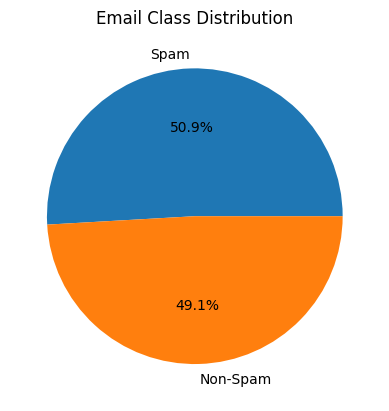

In [9]:
spam_count = len(df[df['label'] == 1])
non_spam_count = len(df[df['label'] == 0])
total_count = len(df)

print(f"Number of Spam Emails: {spam_count}")
print(f"Number of Non-Spam Emails: {non_spam_count}")
print(f"Total Emails: {total_count}")

# Calculate percentage
spam_percent = (spam_count / total_count) * 100
non_spam_percent = (non_spam_count / total_count) * 100

print(f"Percentage of Spam Emails: {spam_percent:.2f}%")
print(f"Percentage of Non-Spam Emails: {non_spam_percent:.2f}%")

# Visualization (using matplotlib)
import matplotlib.pyplot as plt

plt.pie([spam_percent, non_spam_percent], labels=['Spam', 'Non-Spam'], autopct="%1.1f%%")
plt.title("Email Class Distribution")
plt.show()

In [10]:
! pip install seaborn


[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Spam Lengths: 17157
Non-Spam Lengths: 16545


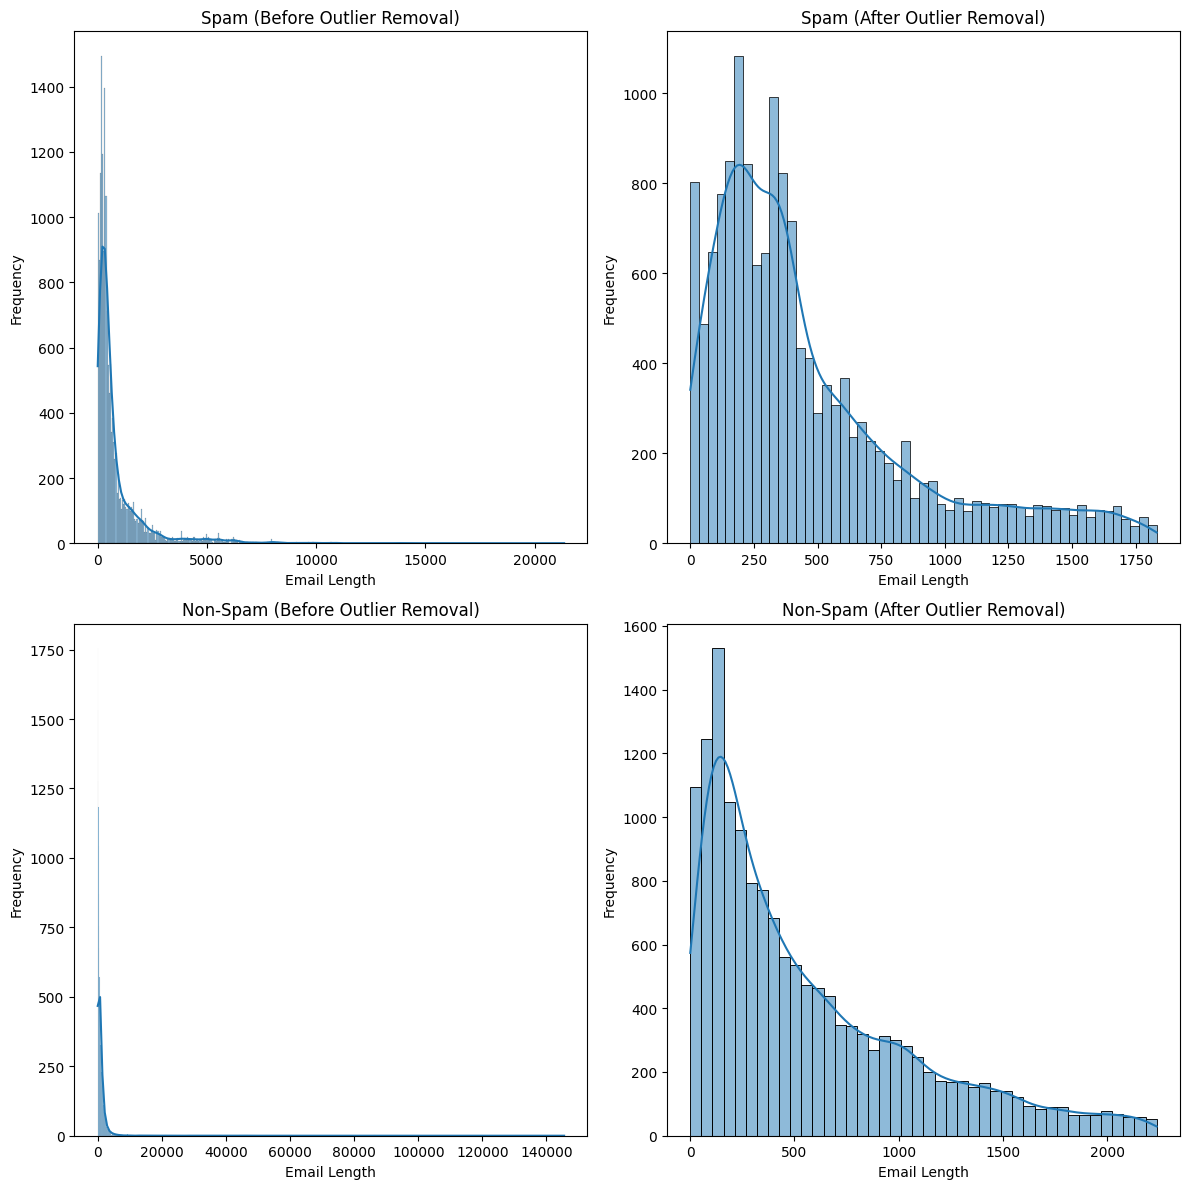

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_iqr_outliers(data):
  """
  This function identifies outliers in a data series using IQR.

  Args:
      data (pandas.Series): The data series containing email lengths.

  Returns:
      tuple: A tuple containing the inlier data and outlier data (as separate pandas.Series).
  """
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5 * iqr
  lower_bound = q1 - 1.5 * iqr
  inliers = data[(data >= lower_bound) & (data <= upper_bound)]
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  return inliers, outliers

# email lengths for spam and non-spam
spam_lengths = df[df['label'] == 1]['clean'].str.len()
non_spam_lengths = df[df['label'] == 0]['clean'].str.len()

print("Spam Lengths:", len(spam_lengths))
print("Non-Spam Lengths:", len(non_spam_lengths))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  

if len(spam_lengths) == 0 or len(non_spam_lengths) == 0:
  print("Warning: Empty data for spam or non-spam lengths. Plots might be empty.")
else:
  # distribution before outlier removal
  sns.histplot(spam_lengths, kde=True, ax=axs[0, 0])
  axs[0, 0].set_title("Spam (Before Outlier Removal)")
  axs[0, 0].set_xlabel("Email Length")
  axs[0, 0].set_ylabel("Frequency")

  sns.histplot(non_spam_lengths, kde=True, ax=axs[1, 0])
  axs[1, 0].set_title("Non-Spam (Before Outlier Removal)")
  axs[1, 0].set_xlabel("Email Length")
  axs[1, 0].set_ylabel("Frequency")

  # IQR to identify outliers
  spam_inliers, spam_outliers = get_iqr_outliers(spam_lengths)
  non_spam_inliers, non_spam_outliers = get_iqr_outliers(non_spam_lengths)

  # Filter DataFrames based on inliers
  filtered_df_spam = df[df['label'] == 1].loc[spam_inliers.index]
  filtered_df_non_spam = df[df['label'] == 0].loc[non_spam_inliers.index]

  # Check for empty data after filtering (optional)
  if len(filtered_df_spam) == 0 or len(filtered_df_non_spam) == 0:
    print("Warning: Filtering removed all data. Plots might be empty.")
  else:
    # Plot distribution after outlier removal
    sns.histplot(filtered_df_spam['clean'].str.len(), kde=True, ax=axs[0, 1])
    axs[0, 1].set_title("Spam (After Outlier Removal)")
    axs[0, 1].set_xlabel("Email Length")
    axs[0, 1].set_ylabel("Frequency")

    sns.histplot(filtered_df_non_spam['clean'].str.len(), kde=True, ax=axs[1, 1])
    axs[1, 1].set_title("Non-Spam (After Outlier Removal)")
    axs[1, 1].set_xlabel("Email Length")
    axs[1, 1].set_ylabel("Frequency")

# Adjust layout (optional)
plt.tight_layout()
plt.show()


In [12]:
# Function to extract n-grams (bigrams and trigrams)
def get_n_grams(text, n):
  n_grams = []
  words = text.split()
  for i in range(len(words) - n + 1):
    n_gram = " ".join(words[i:i+n])
    n_grams.append(n_gram)
  return n_grams

# Create dictionaries to store n-gram frequencies for spam and non-spam
bigram_counts_spam = {}
trigram_counts_spam = {}
bigram_counts_non_spam = {}
trigram_counts_non_spam = {}

for i, row in df.iterrows():
  text = row['clean']
  # Extract bigrams and trigrams
  bigrams = get_n_grams(text, 2)
  trigrams = get_n_grams(text, 3)
  # Check label (spam or non-spam)
  if row['label'] == 1:
    # Update spam n-gram counts
    for bigram in bigrams:
      if bigram in bigram_counts_spam:
        bigram_counts_spam[bigram] += 1
      else:
        bigram_counts_spam[bigram] = 1
    for trigram in trigrams:
      if trigram in trigram_counts_spam:
        trigram_counts_spam[trigram] += 1
      else:
        trigram_counts_spam[trigram] = 1
  else:
    # Update non-spam n-gram counts
    for bigram in bigrams:
      if bigram in bigram_counts_non_spam:
        bigram_counts_non_spam[bigram] += 1
      else:
        bigram_counts_non_spam[bigram] = 1
    for trigram in trigrams:
      if trigram in trigram_counts_non_spam:
        trigram_counts_non_spam[trigram] += 1
      else:
        trigram_counts_non_spam[trigram] = 1

In [13]:
# Top 10 Bigrams (Spam)
print("Top 10 Bigrams (Spam):")
top_10_bigrams_spam = Counter(bigram_counts_spam).most_common(10)
for bigram, count in top_10_bigrams_spam:
  print(f"{bigram}: {count}")

# Top 10 Trigrams (Spam)
print("\nTop 10 Trigrams (Spam):")
top_10_trigrams_spam = Counter(trigram_counts_spam).most_common(10)
for trigram, count in top_10_trigrams_spam:
  print(f"{trigram}: {count}")

# Top 10 Bigrams (Non-Spam)
print("\n\nTop 10 Bigrams (Non-Spam):")
top_10_bigrams_non_spam = Counter(bigram_counts_non_spam).most_common(10)
for bigram, count in top_10_bigrams_non_spam:
  print(f"{bigram}: {count}")

# Top 10 Trigrams (Non-Spam)
print("\nTop 10 Trigrams (Non-Spam):")
top_10_trigrams_non_spam = Counter(trigram_counts_non_spam).most_common(10)
for trigram, count in top_10_trigrams_non_spam:
  print(f"{trigram}: {count}")


Top 10 Bigrams (Spam):
looking statement: 2195
forward looking: 1918
investment advice: 1486
email address: 1482
within email: 1134
would like: 1031
information provided: 1031
risk uncertainty: 1029
section security: 1027
united state: 989

Top 10 Trigrams (Spam):
forward looking statement: 1856
statement within meaning: 756
www computron com: 661
security act section: 589
forward ooking statement: 562
phone mobile email: 557
security exchange act: 549
within meaning section: 537
number risk uncertainty: 529
wish stop future: 527


Top 10 Bigrams (Non-Spam):
ect ect: 15770
vince kaminski: 4072
let know: 3975
original message: 3869
ect cc: 3799
dow jones: 2979
would like: 2444
new york: 2359
please let: 2271
natural gas: 2213

Top 10 Trigrams (Non-Spam):
ect ect cc: 3697
please let know: 1998
vince kaminski ect: 1945
copyright dow jones: 1899
lon ect ect: 1707
dow jones company: 1437
jones company inc: 1437
kaminski ect ect: 1369
unknown database alias: 1332
database alias dbcaps: 1332


In [14]:
# shuffle data for better randomization
df = df.sample(frac=1, random_state=1)

# split into training/validation/test (70/20/10)

train_df, other_df = train_test_split(df, test_size=0.3, random_state=1)
val_df, test_df = train_test_split(other_df, test_size=0.33, random_state=1)

X_train = train_df['clean']
y_train = train_df['label']

X_val = val_df['clean']
y_val = val_df['label']

X_test = test_df['clean']
y_test = test_df['label']

print(len(X_train))
print(len(X_val))
print(len(X_test))

23591
6774
3337


In [15]:
# count tokens in training set
token_counter = {}
for message in train_df['clean']:
  words = nltk.word_tokenize(message)

  for token in words:
    if token in token_counter:
      token_counter[token] += 1
    else:
      token_counter[token] = 1

token_counter

{'thank': 2536,
 'pam': 102,
 'wrote': 359,
 'another': 1613,
 'term': 4220,
 'paper': 1188,
 'john': 2799,
 'ganguzza': 7,
 'neeraj': 4,
 'hingorani': 4,
 'grant': 801,
 'johnson': 331,
 'duane': 58,
 'maue': 7,
 'rishad': 7,
 'patel': 49,
 'eric': 371,
 'van': 277,
 'stone': 199,
 'palo': 163,
 'yoshiuro': 1,
 'grade': 499,
 'please': 13960,
 'confirm': 677,
 'vince': 5977,
 'see': 4756,
 'went': 470,
 'happy': 783,
 'meet': 1433,
 'jinbaek': 108,
 'time': 10301,
 'slot': 94,
 'anyone': 774,
 'else': 617,
 'scheduled': 685,
 'easily': 324,
 'hiim': 2,
 'lunch': 419,
 'molly': 262,
 'forwarded': 2728,
 'magee': 96,
 'ect': 25397,
 'pm': 6695,
 'shawn': 54,
 'grady': 26,
 'kaminski': 3322,
 'stinson': 719,
 'gibner': 439,
 'tanya': 351,
 'tamarchenko': 156,
 'bob': 1074,
 'lee': 503,
 'na': 1311,
 'vasant': 296,
 'shanbhogue': 189,
 'cc': 6585,
 'shirley': 1239,
 'crenshaw': 805,
 'anita': 317,
 'dupont': 130,
 'interview': 1099,
 'schedule': 2579,
 'kim': 384,
 'find': 2390,
 'packet'

In [16]:
def keep_token(proccessed_token, threshold):
  if proccessed_token not in token_counter:
    return False
  else:
    # add condition to check length of token
    return token_counter[proccessed_token] > threshold and len(proccessed_token) > 3


In [17]:
# for the current dataset 6000 is a good value which generates a
# set with an acceptable length to be considered a feature set for the
# machine learning algorithms

# this is the Bag of Words approach

features = set()

for token in token_counter:
  if keep_token(token, 4500):
    features.add(token)

features = list(features)
features

['product',
 'work',
 'system',
 'week',
 'power',
 'year',
 'number',
 'energy',
 'mail',
 'sent',
 'deal',
 'would',
 'price',
 'security',
 'business',
 'financial',
 'vince',
 'information',
 'make',
 'trading',
 'know',
 'thanks',
 'risk',
 'need',
 'said',
 'corp',
 'also',
 'group',
 'could',
 'investment',
 'statement',
 'share',
 'company',
 'please',
 'email',
 'message',
 'million',
 'market',
 'time',
 'report',
 'money',
 'like',
 'service',
 'stock']

In [18]:
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}
token_to_index_mapping

{'product': 0,
 'work': 1,
 'system': 2,
 'week': 3,
 'power': 4,
 'year': 5,
 'number': 6,
 'energy': 7,
 'mail': 8,
 'sent': 9,
 'deal': 10,
 'would': 11,
 'price': 12,
 'security': 13,
 'business': 14,
 'financial': 15,
 'vince': 16,
 'information': 17,
 'make': 18,
 'trading': 19,
 'know': 20,
 'thanks': 21,
 'risk': 22,
 'need': 23,
 'said': 24,
 'corp': 25,
 'also': 26,
 'group': 27,
 'could': 28,
 'investment': 29,
 'statement': 30,
 'share': 31,
 'company': 32,
 'please': 33,
 'email': 34,
 'message': 35,
 'million': 36,
 'market': 37,
 'time': 38,
 'report': 39,
 'money': 40,
 'like': 41,
 'service': 42,
 'stock': 43}

In [19]:
import numpy as np

def message_to_count_vector(message):
  count_vector = np.zeros(len(features))

  processed_list_of_tokens = nltk.word_tokenize(message)

  for token in processed_list_of_tokens:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1

  return count_vector

In [20]:
message_to_count_vector(X_train.iloc[900])

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [21]:
# 1 spam; 0 not spam (looking at the array above we expect a 1)
y_train.iloc[900]

1

In [22]:
def extract_features_and_labels_for_BOW(dataframe):
  # Extract labels and convert to integer type
  labels = dataframe['label'].values.astype(int)

  # Extract messages
  messages = dataframe['clean']
  vector_counts = []

  # Convert each message to a count vector
  for msg in messages:
    vector = message_to_count_vector(msg)
    vector_counts.append(vector)

  # Convert list of count vectors to a numpy array and cast to integer type
  feature_matrix = np.asarray(vector_counts).astype(int)

  return feature_matrix, labels


In [23]:
X_train_BOW, Y_train_BOW = extract_features_and_labels_for_BOW(train_df)

X_val_BOW, Y_val_BOW = extract_features_and_labels_for_BOW(val_df)

X_test_BOW, Y_test_BOW = extract_features_and_labels_for_BOW(test_df)

X_train_BOW.shape, Y_train_BOW.shape, X_test_BOW.shape, Y_test_BOW.shape

((23591, 44), (23591,), (3337, 44), (3337,))

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_BOW)

X_train_BOW, X_test_BOW, X_val_BOW = scaler.transform(X_train_BOW), scaler.transform(X_test_BOW), scaler.transform(X_val_BOW)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

X_train_val_BOW = np.concatenate((X_train_BOW, X_val_BOW), axis=0)
Y_train_val_BOW = np.concatenate((Y_train_BOW, Y_val_BOW), axis=0)

lrBOW = LogisticRegression(solver='liblinear', max_iter=30000)
grid_search = GridSearchCV(lrBOW, hyperparameters, cv=5)
best_model = grid_search.fit(X_train_val_BOW, Y_train_val_BOW)
best_params = best_model.best_params_
print('Best Parameters:', best_params)
print('Best Score:', best_model.best_score_)
X_train_BOW, X_val_BOW, Y_train_BOW, Y_val_BOW = train_test_split(X_train_val_BOW, Y_train_val_BOW, test_size=0.2, random_state=42)


# Train the model with the best parameters
lrBOW = LogisticRegression(solver='liblinear', max_iter=30000, **best_params)
lrBOW.fit(X_train_BOW, Y_train_BOW)

val_pred = lrBOW.predict(X_val_BOW)
print("Logistic Regression (BoW) Validation Accuracy:", accuracy_score(Y_val_BOW, val_pred))
print(classification_report(Y_val_BOW, lrBOW.predict(X_val_BOW)))

test_pred = lrBOW.predict(X_test_BOW)
print("Logistic Regression (BoW) Test Accuracy:", accuracy_score(Y_test_BOW, test_pred))
print(classification_report(Y_test_BOW, lrBOW.predict(X_test_BOW)))


def predict_lrbow(email):
    # Preprocess the email
    preprocessed_email = preprocess_text(email)  # You need to define this function

    # Convert the preprocessed email to a count vector
    email_vector = message_to_count_vector(preprocessed_email)

    # Reshape the email vector to 2D array as the model expects input in this shape
    email_vector = email_vector.reshape(1, -1)

    # Use the model to predict whether the email is spam or not
    prediction = lrBOW.predict(email_vector)

    return prediction



Best Parameters: {'C': 1000, 'penalty': 'l1'}
Best Score: 0.8013502387617322
Logistic Regression (BoW) Validation Accuracy: 0.7986168285855426
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      3030
           1       0.75      0.90      0.82      3043

    accuracy                           0.80      6073
   macro avg       0.81      0.80      0.80      6073
weighted avg       0.81      0.80      0.80      6073

Logistic Regression (BoW) Test Accuracy: 0.7983218459694337
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1665
           1       0.75      0.90      0.82      1672

    accuracy                           0.80      3337
   macro avg       0.81      0.80      0.80      3337
weighted avg       0.81      0.80      0.80      3337



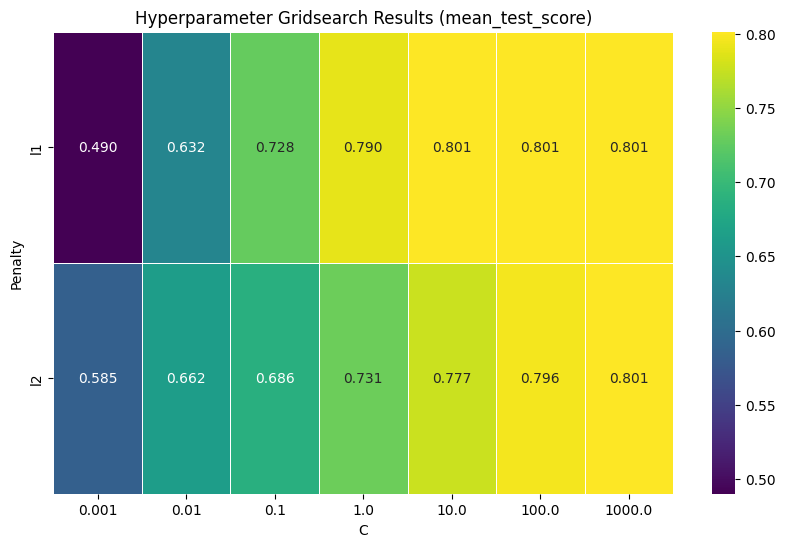

In [26]:
# Fit the GridSearchCV again
grid_search = GridSearchCV(lrBOW, hyperparameters, cv=5)
grid_search.fit(X_train_val_BOW, Y_train_val_BOW)

# Get the results of the grid search
cv_results = grid_search.cv_results_

# Create a DataFrame from the cv_results
df_cv_results = pd.DataFrame(cv_results)

# Extract the mean_test_score values for each hyperparameter combination
scores_matrix = df_cv_results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", linewidths=.5, cmap='viridis')
plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
plt.xlabel('C')
plt.ylabel('Penalty')
plt.show()


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [28]:
vectorizer = TfidfVectorizer()

In [29]:
def extract_features_and_labels_tfidf(dataframe, fit_vectorizer=False):

    labels = dataframe['label'].values.astype(int)
    messages = dataframe['clean']

    if fit_vectorizer:
        feature_matrix = vectorizer.fit_transform(messages)
    else:
        feature_matrix = vectorizer.transform(messages)

    return feature_matrix, labels

Best Parameters: {'C': 1000, 'penalty': 'l2'}


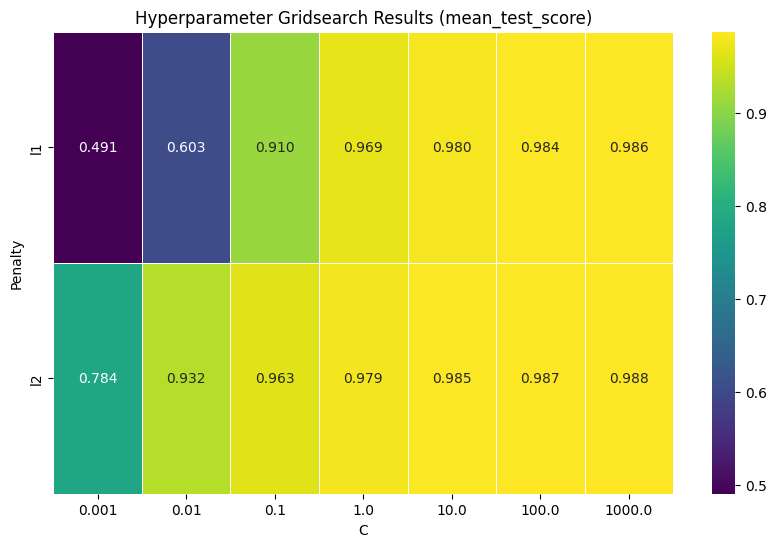

Logistic Regression (TF-IDF) Validation Accuracy: 0.9873043991733097
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3308
           1       0.98      0.99      0.99      3466

    accuracy                           0.99      6774
   macro avg       0.99      0.99      0.99      6774
weighted avg       0.99      0.99      0.99      6774

Logistic Regression (TF-IDF) Test Accuracy: 0.989211866946359
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1665
           1       0.98      0.99      0.99      1672

    accuracy                           0.99      3337
   macro avg       0.99      0.99      0.99      3337
weighted avg       0.99      0.99      0.99      3337



In [30]:
def train_logistic_regression_tfidf(train_df, val_df, test_df):
    
    X_train_TFIDF, Y_train_TFIDF = extract_features_and_labels_tfidf(train_df, fit_vectorizer = True)

    X_val_TFIDF, Y_val_TFIDF = extract_features_and_labels_tfidf(val_df)

    X_test_TFIDF, Y_test_TFIDF = extract_features_and_labels_tfidf(test_df)

    lr_tfidf = LogisticRegression(solver='liblinear', max_iter=30000)
    grid_search = GridSearchCV(lr_tfidf, hyperparameters, cv=5)
    grid_search.fit(X_train_TFIDF, Y_train_TFIDF)
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)
    cv_results = grid_search.cv_results_
    df_cv_results = pd.DataFrame(cv_results)


    lr_tfidf = LogisticRegression(solver='liblinear', max_iter=30000, **best_params)
    lr_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)
    # Extract the mean_test_score values for each hyperparameter combination
    scores_matrix = df_cv_results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

# Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", linewidths=.5, cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('C')
    plt.ylabel('Penalty')
    plt.show()  

    val_pred = lr_tfidf.predict(X_val_TFIDF)
    print("Logistic Regression (TF-IDF) Validation Accuracy:", accuracy_score(Y_val_TFIDF, val_pred))
    print(classification_report(Y_val_TFIDF, val_pred))

    test_pred = lr_tfidf.predict(X_test_TFIDF)
    print("Logistic Regression (TF-IDF) Test Accuracy:", accuracy_score(Y_test_TFIDF, test_pred))
    print(classification_report(Y_test_TFIDF, test_pred))
    
    return lr_tfidf

lr_tfidf = train_logistic_regression_tfidf(train_df, val_df, test_df)

def predict_lrtfidf(email):
    # Preprocess the email
    preprocessed_email = preprocess_text(email)

    # Convert the preprocessed email to a TF-IDF vector
    email_vector = vectorizer.transform([preprocessed_email])

    # Use the model to predict whether the email is spam or not
    prediction = lr_tfidf.predict(email_vector)

    return prediction

Best Parameters: {'alpha': 1, 'norm': False}


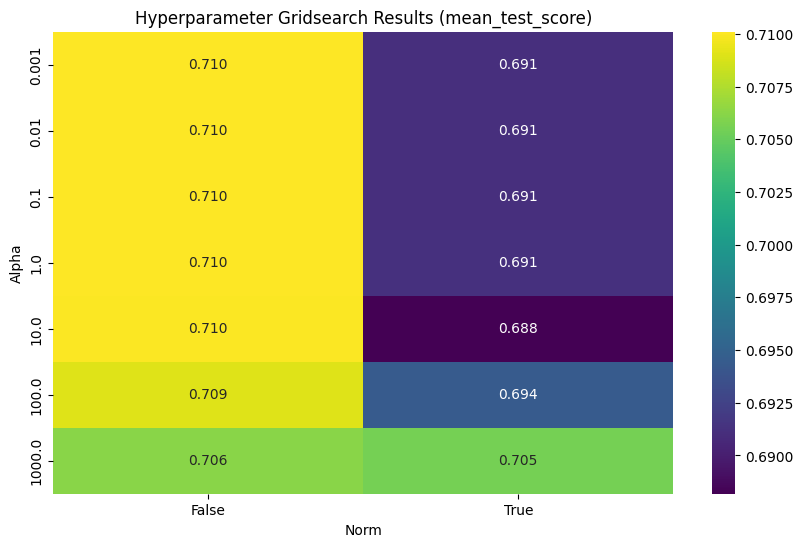

Naive Bayes (BoW) Validation Accuracy: 0.7100679067020963
              precision    recall  f1-score   support

           0       0.66      0.86      0.74      3308
           1       0.81      0.57      0.67      3466

    accuracy                           0.71      6774
   macro avg       0.73      0.71      0.71      6774
weighted avg       0.73      0.71      0.70      6774

Naive Bayes (BoW) Test Accuracy: 0.7231045849565478
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1665
           1       0.80      0.60      0.68      1672

    accuracy                           0.72      3337
   macro avg       0.74      0.72      0.72      3337
weighted avg       0.74      0.72      0.72      3337



In [31]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB

def train_naive_bayes_bow(train_df, val_df, test_df):
    
    X_train_BOW, Y_train_BOW = extract_features_and_labels_for_BOW(train_df)

    X_val_BOW, Y_val_BOW = extract_features_and_labels_for_BOW(val_df)

    X_test_BOW, Y_test_BOW = extract_features_and_labels_for_BOW(test_df)

    # Define the hyperparameters and the values to test
    hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'norm': [True, False]
    }

    # Initialize the Naive Bayes model
    cnb_bow = ComplementNB()

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(cnb_bow, hyperparameters, cv=5)

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train_BOW, Y_train_BOW)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)

    # Train the model with the best parameters
    cnb_bow = ComplementNB(**best_params)
    cnb_bow.fit(X_train_BOW, Y_train_BOW)

    # Get the results of the grid search
    cv_results = grid_search.cv_results_

    # Create a DataFrame from the cv_results
    df_cv_results = pd.DataFrame(cv_results)

    # Extract the mean_test_score values for each alpha
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    
    # Create a heatmap for the mean_test_score values
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('Norm')
    plt.ylabel('Alpha')
    plt.show()

    # Validation evaluation
    val_pred = cnb_bow.predict(X_val_BOW)
    print("Naive Bayes (BoW) Validation Accuracy:", accuracy_score(Y_val_BOW, val_pred))
    print(classification_report(Y_val_BOW, val_pred))

    # Test evaluation
    test_pred = cnb_bow.predict(X_test_BOW)
    print("Naive Bayes (BoW) Test Accuracy:", accuracy_score(Y_test_BOW, test_pred))
    print(classification_report(Y_test_BOW, test_pred))

    return cnb_bow

cnb_bow = train_naive_bayes_bow(train_df, val_df, test_df)

def predict_cnbbow(email):
    # Preprocess the email
    preprocessed_email = preprocess_text(email)  # You need to define this function

    # Convert the preprocessed email to a count vector
    email_vector = message_to_count_vector(preprocessed_email)

    # Reshape the email vector to 2D array as the model expects input in this shape
    email_vector = email_vector.reshape(1, -1)

    # Use the model to predict whether the email is spam or not
    prediction = cnb_bow.predict(email_vector)

    return prediction


Best Parameters: {'alpha': 0.01, 'norm': False}


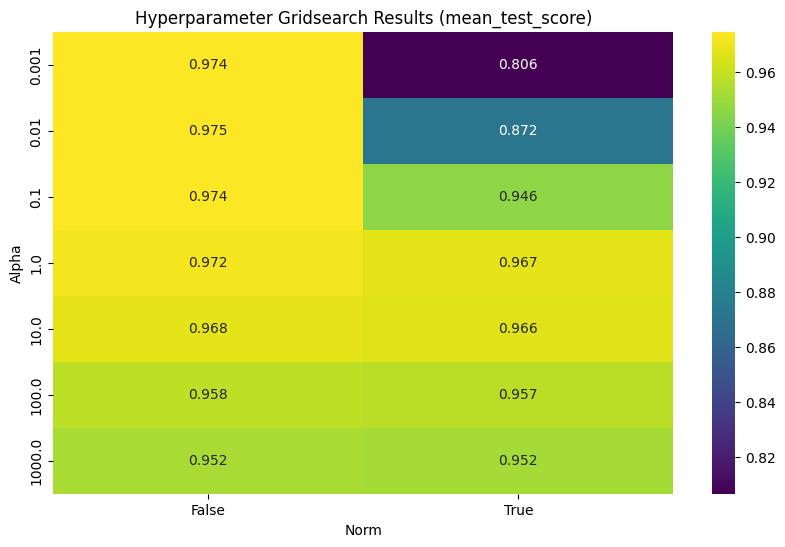

Naive Bayes (TF-IDF) Validation Accuracy: 0.9782993799822852
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3308
           1       0.99      0.97      0.98      3466

    accuracy                           0.98      6774
   macro avg       0.98      0.98      0.98      6774
weighted avg       0.98      0.98      0.98      6774

Naive Bayes (TF-IDF) Test Accuracy: 0.974228348816302
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1665
           1       0.99      0.96      0.97      1672

    accuracy                           0.97      3337
   macro avg       0.97      0.97      0.97      3337
weighted avg       0.97      0.97      0.97      3337



In [32]:
def train_naive_bayes_tfidf(train_df, val_df, test_df):
    X_train_TFIDF, Y_train_TFIDF = extract_features_and_labels_tfidf(train_df, fit_vectorizer = True)

    X_val_TFIDF, Y_val_TFIDF = extract_features_and_labels_tfidf(val_df)

    X_test_TFIDF, Y_test_TFIDF = extract_features_and_labels_tfidf(test_df)

    hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'norm': [True, False]
    }

    cnb_tfidf = ComplementNB()
    cnb_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)

    grid_search = GridSearchCV(cnb_tfidf, hyperparameters, cv=5)

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train_TFIDF, Y_train_TFIDF)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)
    
    cnb_tfidf = ComplementNB(**best_params)
    cnb_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)

    # Get the results of the grid search
    cv_results = grid_search.cv_results_

    # Create a DataFrame from the cv_results
    df_cv_results = pd.DataFrame(cv_results)

    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    
    # Create a heatmap for the mean_test_score values
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('Norm')
    plt.ylabel('Alpha')
    plt.show()

    # Validation evaluation
    val_pred = cnb_tfidf.predict(X_val_TFIDF)
    print("Naive Bayes (TF-IDF) Validation Accuracy:", accuracy_score(Y_val_TFIDF, val_pred))
    print(classification_report(Y_val_TFIDF, val_pred))

    # Test evaluation
    test_pred = cnb_tfidf.predict(X_test_TFIDF)
    print("Naive Bayes (TF-IDF) Test Accuracy:", accuracy_score(Y_test_TFIDF, test_pred))
    print(classification_report(Y_test_TFIDF, test_pred))
    
    return cnb_tfidf

cnb_tfidf = train_naive_bayes_tfidf(train_df, val_df, test_df)

def predict_cnbtfidf(email):
    # Preprocess the email
    preprocessed_email = preprocess_text(email)  # You need to define this function

    # Convert the preprocessed email to a TF-IDF vector
    email_vector = vectorizer.transform([preprocessed_email])

    # Use the model to predict whether the email is spam or not
    prediction = cnb_tfidf.predict(email_vector)

    return prediction



In [33]:
# fit vectorizer on the training data
X_train_TFIDF = vectorizer.fit_transform(X_train)
X_val_TFIDF = vectorizer.transform(X_val)
X_test_TFIDF = vectorizer.transform(X_test)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


# hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['auto', 0.1, 1, 10],
}

# initialize SVM classifier
svm_classifier = SVC()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid search with stratified K-fold cross-validation
grid_search = GridSearchCV(
    svm_classifier,
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
)

# fit model on training data
grid_search.fit(X_train_TFIDF, y_train)

# best parameters and model
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

# best model on validation data
val_pred = best_model.predict(X_val_TFIDF)
print("Tuned SVM Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred))

# best model on test data
test_pred = best_model.predict(X_test_TFIDF)
print("Tuned SVM Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Tuned SVM Validation Accuracy: 0.9871567759078831
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3308
           1       0.98      0.99      0.99      3466

    accuracy                           0.99      6774
   macro avg       0.99      0.99      0.99      6774
weighted avg       0.99      0.99      0.99      6774

Tuned SVM Test Accuracy: 0.9889121965837578
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1665
           1       0.98      0.99      0.99      1672

    accuracy                           0.99      3337
   macro avg       0.99      0.99      0.99      3337
weighted avg       0.99      0.99      0.99      3337



Best Parameters:
C: 50
Kernel: rbf
Gamma: 0.1


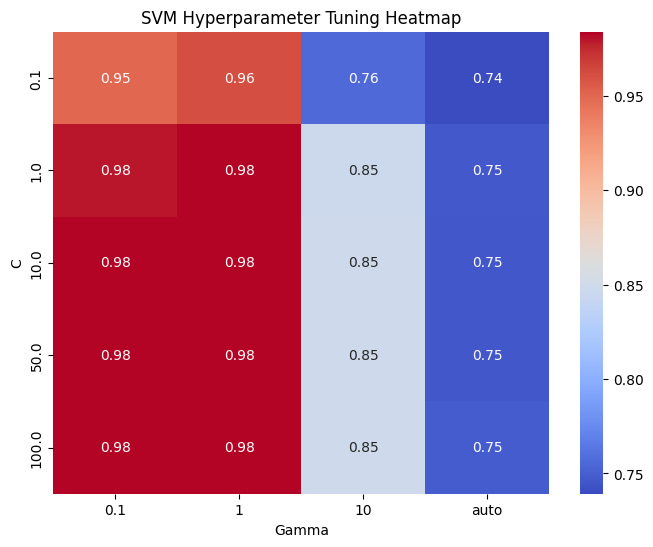

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Best Parameters:")
print("C:", best_parameters['C'])
print("Kernel:", best_parameters['kernel'])
print("Gamma:", best_parameters['gamma'])


# Extract the search results
results_df = pd.DataFrame(grid_search.cv_results_)

# Create a heatmap for the accuracy scores
heatmap_data = results_df.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True)
plt.title("SVM Hyperparameter Tuning Heatmap")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()


In [37]:

def predict_svm(email):
  """
  Predicts whether an email is spam or not using the trained SVM model.

  Args:
      email: The email content as a string.

  Returns:
      A list containing the predicted class label (spam or not spam).
  """
  # Preprocess the email
  preprocessed_email = preprocess_text(email)  # You need to define this function

  # Convert the preprocessed email to a TF-IDF vector
  email_vector = vectorizer.transform([preprocessed_email])


  # Use the best model to predict whether the email is spam or not
  prediction = best_model.predict(email_vector)

  return prediction


predict_svm("Dear Martin, The Board of Examiners approved your request for the following elective: EBC2144 - Technology Entrepreneurship, P2, ECTS 6.5. Please find your original request with your fully approved elective semester plan attached.")


array([0], dtype=int64)

In [38]:
models = {
    'lrBOW': (lrBOW, predict_lrbow),
    'lr_tfidf': (lr_tfidf, predict_lrtfidf),
    'cnb_bow': (cnb_bow, predict_cnbbow),
    'cnb_tfidf': (cnb_tfidf, predict_cnbtfidf),
    'svm': (best_model, predict_svm)
}


In [ ]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [39]:
import joblib

# Save the Logistic Regression (BoW) model
joblib.dump(lrBOW, 'lrBOW_model.pkl')

# Save the Logistic Regression (TF-IDF) model
joblib.dump(lr_tfidf, 'lr_tfidf_model.pkl')

# Save the Naive Bayes (BoW) model
joblib.dump(cnb_bow, 'cnb_bow_model.pkl')

# Save the Naive Bayes (TF-IDF) model
joblib.dump(cnb_tfidf, 'cnb_tfidf_model.pkl')

# Save the SVM model
joblib.dump(best_model, 'svm_model.pkl')

joblib.dump(vectorizer, 'vectorizer.pkl')

joblib.dump(features, 'features.pkl')



['features.pkl']